In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = './NanumFontSetup_TTF_BARUNGOTHIC/NanumBarunGothic.ttf'
import matplotlib.font_manager as fm
fontprop = fm.FontProperties(fname=font_path, size=18)
import seaborn as sns
import shap

In [2]:
%%time
# Read Data
basedir = './Training/training_data_ver_16/'
training_data_df = pd.read_csv(basedir + 'training_data_ver_16.csv').drop(columns=['주택가격지수']).dropna()
#training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 1500)]
training_data_df.columns = [col.replace(' ','_').replace('·','_') for col in training_data_df.columns]

Wall time: 1min 23s


In [3]:
training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 3000)]

In [4]:
training_data_df['호수대비부속건축물면적'] = training_data_df['부속건축물면적'] / training_data_df['총호수']

In [5]:
training_data_df = training_data_df[(training_data_df['호수대비부속건축물면적'] < 100)]

In [6]:
training_data_df = training_data_df.reset_index(drop=True)

In [7]:
cols_to_log = ['총건축면적', '총연면적', '총용적률연면적', '토지면적', '부속건축물면적']
for col in cols_to_log:
    training_data_df[col] = training_data_df[col].apply(np.log1p)

In [8]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')

In [9]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

296

In [10]:
cat_cols = [col for col in training_data_df.columns if col in cat_cols_list]
len(cat_cols)

296

In [11]:
cat_cols[:10]

['건물나이',
 'trade_type',
 '표준지여부',
 '지목명',
 '용도지역명1',
 '용도지역명2',
 '토지이동상황',
 '지형높이',
 '지형형상',
 '도로접면']

In [12]:
shap_summary_df = pd.read_csv(basedir + 'shap_top_45.csv', index_col=[0]).sort_values(['shap_summary_mean'], ascending=False)
print(shap_summary_df.shape)
shap_summary_df.head()

(45, 6)


,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,94.544142,93.736138,92.205033,94.799576,94.476787,93.952335
공시지가(만원),75.693267,77.992167,76.293766,77.415995,81.337172,77.746473
year_linear,64.345777,65.954926,62.499814,63.805882,65.183594,64.357999
건축년도,47.427376,46.097969,45.861742,47.963608,48.121648,47.094468
전용면적,40.084776,35.712764,37.732474,35.497766,38.859649,37.577486


In [13]:
shap_summary_df.tail(50)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,94.544142,93.736138,92.205033,94.799576,94.476787,93.952335
공시지가(만원),75.693267,77.992167,76.293766,77.415995,81.337172,77.746473
year_linear,64.345777,65.954926,62.499814,63.805882,65.183594,64.357999
건축년도,47.427376,46.097969,45.861742,47.963608,48.121648,47.094468
전용면적,40.084776,35.712764,37.732474,35.497766,38.859649,37.577486
ynorm,31.586869,31.023605,30.970457,31.102520,30.698971,31.076484
xy,23.870775,21.066993,21.420318,22.807127,22.478437,22.328730
x_2nd,18.709031,19.346512,19.691544,20.575816,19.923733,19.649327
주건축물수,14.456543,12.955188,13.557963,13.472946,14.560911,13.800710
층mean,10.952284,10.225442,9.948209,12.713209,11.218072,11.011443


In [14]:
top_44_df = shap_summary_df.iloc[:44,:]
print(top_44_df.shape)

(44, 6)


In [15]:
top_44_df.head()

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,94.544142,93.736138,92.205033,94.799576,94.476787,93.952335
공시지가(만원),75.693267,77.992167,76.293766,77.415995,81.337172,77.746473
year_linear,64.345777,65.954926,62.499814,63.805882,65.183594,64.357999
건축년도,47.427376,46.097969,45.861742,47.963608,48.121648,47.094468
전용면적,40.084776,35.712764,37.732474,35.497766,38.859649,37.577486


In [16]:
top_44_df.tail(20)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
도로접면,2.793065,2.585900,2.825948,2.594459,2.560780,2.672030
부속건축물수,2.493910,2.164293,2.755030,2.976949,2.424481,2.562932
가축사육제한구역,2.586055,2.879451,2.155697,2.256171,2.670322,2.509539
지붕_평지붕_fraction,2.755149,2.463623,2.389780,2.390678,2.332340,2.466314
지형높이,2.199142,2.563723,2.431274,2.299531,2.593021,2.417338
부속건축물면적,2.128858,2.351731,2.669659,2.447728,2.323100,2.384215
건물나이,2.375484,2.339772,2.315971,2.310088,2.108145,2.289892
층min,2.291267,2.128667,2.236049,2.333784,2.368059,2.271565
month_sin,2.283871,2.154983,2.059273,2.149612,2.182511,2.166050
옥외자주식대수,2.033799,1.932405,2.104735,2.222263,2.421014,2.142843


In [17]:
target_cols = ['금액(만원)', '가격면적', 'target_log_transformed', 'targetarea_log_transformed', '지번주소']

In [18]:
training_data_df = training_data_df[top_44_df.index.tolist()+target_cols]
print(training_data_df.shape)
training_data_df.head()

(3658226, 49)


,trade_type,공시지가(만원),year_linear,건축년도,전용면적,ynorm,xy,x_2nd,주건축물수,층mean,토지이동상황,총건축면적,호수대비부속건축물면적,xnorm,옥내자주식대수,아파트지구,호수대비연면적,총호수,y_2nd,호수대비주차수,층,용도지역명1,층norm,지구단위계획구역,도로접면,부속건축물수,가축사육제한구역,지붕_평지붕_fraction,지형높이,부속건축물면적,건물나이,층min,month_sin,옥외자주식대수,(한강)폐기물매립시설_설치제한지역,공원,지형형상,x_sin,y_sin,x_cos,y_cos,정비구역,제3종일반주거지역,제1종지구단위계획구역,금액(만원),가격면적,target_log_transformed,targetarea_log_transformed,지번주소
0,0,921.0,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,0,6.27131,0.0,5579.095707,0.0,0,98.537963,54.0,4.094180e+07,0.0,2,0,0.222222,0,0,0.0,0,1.0,0,0.0,0,9.0,-0.866025,0.0,0,0,0,-0.364267,-0.920469,0.931294,0.390815,0,0,0,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
1,0,921.0,7.916667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,0,6.27131,0.0,5579.095707,0.0,0,98.537963,54.0,4.094180e+07,0.0,2,0,0.222222,0,0,0.0,0,1.0,0,0.0,0,9.0,-0.500000,0.0,0,0,0,-0.364267,-0.920469,0.931294,0.390815,0,0,0,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
2,1,921.0,7.000000,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,0,6.27131,0.0,5579.095707,0.0,0,98.537963,54.0,4.094180e+07,0.0,4,0,0.444444,0,0,0.0,0,1.0,0,0.0,0,9.0,0.000000,0.0,0,0,0,-0.364267,-0.920469,0.931294,0.390815,0,0,0,35000.0,450.160772,10.463103,6.109605,서울특별시 강남구 개포동 655-2
3,1,921.0,7.166667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,0,6.27131,0.0,5579.095707,0.0,0,98.537963,54.0,4.094180e+07,0.0,9,0,1.000000,0,0,0.0,0,1.0,0,0.0,0,9.0,0.866025,0.0,0,0,0,-0.364267,-0.920469,0.931294,0.390815,0,0,0,32000.0,411.575563,10.373491,6.019993,서울특별시 강남구 개포동 655-2
4,1,921.0,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,0,6.27131,0.0,5579.095707,0.0,0,98.537963,54.0,4.094180e+07,0.0,1,0,0.111111,0,0,0.0,0,1.0,0,0.0,0,9.0,-0.866025,0.0,0,0,0,-0.364267,-0.920469,0.931294,0.390815,0,0,0,37000.0,475.884244,10.518673,6.165175,서울특별시 강남구 개포동 655-2


# Training

In [19]:
from sklearn.model_selection import KFold, GroupKFold

In [20]:
import lightgbm as lgb

In [21]:
from sklearn.metrics import r2_score

In [22]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
cat_cols = [col for col in cat_cols if col in training_data_df.columns.tolist()]
len(cat_cols)

15

In [24]:
# Next things to do:
# 1. Do Variance Inflation Factor (VIF) analysis.
# 2. keep the feature with the highest shap value
# 3. Retrain
# 4. Remove 1 feature at a time and find out the set of feature with the lowest loss.
# 5. Retrain
# 6. Continue production prep

Fold 0 start
(2926580, 44)
y dist plot


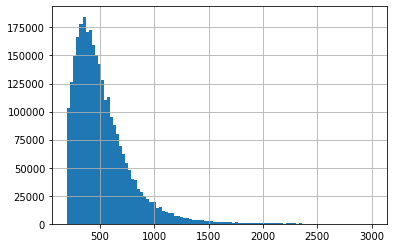

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.171815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5928
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 44


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.5819
[100]	valid_0's huber: 64.6769
[150]	valid_0's huber: 58.4868
[200]	valid_0's huber: 54.7892
[250]	valid_0's huber: 52.4335
[300]	valid_0's huber: 50.6495
[350]	valid_0's huber: 49.3433
[400]	valid_0's huber: 48.2201
[450]	valid_0's huber: 47.166
[500]	valid_0's huber: 46.3199
[550]	valid_0's huber: 45.7275
[600]	valid_0's huber: 45.0844
[650]	valid_0's huber: 44.5257
[700]	valid_0's huber: 44.0003
[750]	valid_0's huber: 43.5301
[800]	valid_0's huber: 43.1273
[850]	valid_0's huber: 42.7646
[900]	valid_0's huber: 42.3928
[950]	valid_0's huber: 42.0344
[1000]	valid_0's huber: 41.7737
[1050]	valid_0's huber: 41.4531
[1100]	valid_0's huber: 41.1562
[1150]	valid_0's huber: 40.8978
[1200]	valid_0's huber: 40.663
[1250]	valid_0's huber: 40.4492
[1300]	valid_0's huber: 40.2575
[1350]	valid_0's huber: 40.0649
[1400]	valid_0's huber: 39.8749
[1450]	va

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


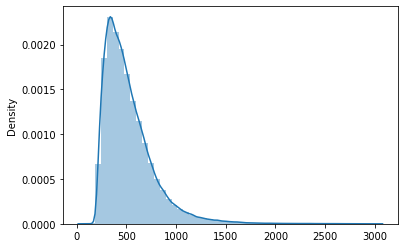

Fold 0 end
Fold 1 start
(2926581, 44)
y dist plot


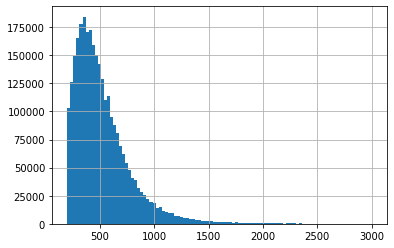

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.162428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5929
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 44


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.755320
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.6868
[100]	valid_0's huber: 64.8714
[150]	valid_0's huber: 58.6098
[200]	valid_0's huber: 54.9084
[250]	valid_0's huber: 52.6587
[300]	valid_0's huber: 50.9087
[350]	valid_0's huber: 49.4915
[400]	valid_0's huber: 48.3808
[450]	valid_0's huber: 47.5154
[500]	valid_0's huber: 46.694
[550]	valid_0's huber: 45.9544
[600]	valid_0's huber: 45.3165
[650]	valid_0's huber: 44.843
[700]	valid_0's huber: 44.3553
[750]	valid_0's huber: 43.8496
[800]	valid_0's huber: 43.3635
[850]	valid_0's huber: 42.9276
[900]	valid_0's huber: 42.5378
[950]	valid_0's huber: 42.159
[1000]	valid_0's huber: 41.8494
[1050]	valid_0's huber: 41.5655
[1100]	valid_0's huber: 41.2737
[1150]	valid_0's huber: 40.9791
[1200]	valid_0's huber: 40.7121
[1250]	valid_0's huber: 40.4926
[1300]	valid_0's huber: 40.2696
[1350]	valid_0's huber: 40.0588
[1400]	valid_0's huber: 39.8444
[1450]	val

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


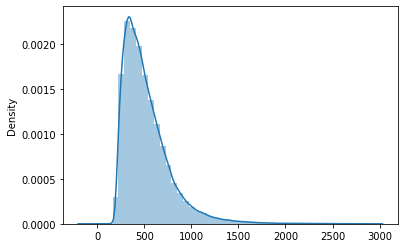

Fold 1 end
Fold 2 start
(2926581, 44)
y dist plot


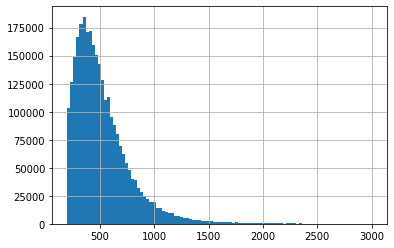

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.168684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5931
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 44


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.648130
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.481
[100]	valid_0's huber: 64.779
[150]	valid_0's huber: 58.5036
[200]	valid_0's huber: 54.7969
[250]	valid_0's huber: 52.4004
[300]	valid_0's huber: 50.6536
[350]	valid_0's huber: 49.3018
[400]	valid_0's huber: 48.1567
[450]	valid_0's huber: 47.193
[500]	valid_0's huber: 46.4043
[550]	valid_0's huber: 45.7267
[600]	valid_0's huber: 45.0621
[650]	valid_0's huber: 44.4573
[700]	valid_0's huber: 43.9494
[750]	valid_0's huber: 43.5026
[800]	valid_0's huber: 43.0684
[850]	valid_0's huber: 42.6907
[900]	valid_0's huber: 42.335
[950]	valid_0's huber: 42.0768
[1000]	valid_0's huber: 41.7678
[1050]	valid_0's huber: 41.4826
[1100]	valid_0's huber: 41.2275
[1150]	valid_0's huber: 41.0382
[1200]	valid_0's huber: 40.8037
[1250]	valid_0's huber: 40.5721
[1300]	valid_0's huber: 40.3456
[1350]	valid_0's huber: 40.1147
[1400]	valid_0's huber: 39.917
[1450]	valid

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


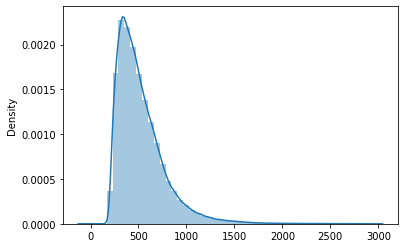

Fold 2 end
Fold 3 start
(2926581, 44)
y dist plot


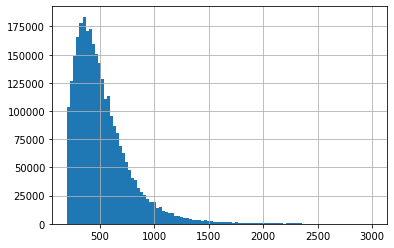

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.145245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5925
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 44


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.732369
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.5235
[100]	valid_0's huber: 64.7441
[150]	valid_0's huber: 58.5029
[200]	valid_0's huber: 55.0134
[250]	valid_0's huber: 52.6372
[300]	valid_0's huber: 50.9384
[350]	valid_0's huber: 49.5147
[400]	valid_0's huber: 48.3623
[450]	valid_0's huber: 47.4009
[500]	valid_0's huber: 46.5172
[550]	valid_0's huber: 45.8114
[600]	valid_0's huber: 45.2441
[650]	valid_0's huber: 44.704
[700]	valid_0's huber: 44.2132
[750]	valid_0's huber: 43.7065
[800]	valid_0's huber: 43.2916
[850]	valid_0's huber: 42.9304
[900]	valid_0's huber: 42.5903
[950]	valid_0's huber: 42.2123
[1000]	valid_0's huber: 41.854
[1050]	valid_0's huber: 41.558
[1100]	valid_0's huber: 41.2622
[1150]	valid_0's huber: 40.9859
[1200]	valid_0's huber: 40.7164
[1250]	valid_0's huber: 40.4591
[1300]	valid_0's huber: 40.2487
[1350]	valid_0's huber: 40.0789
[1400]	valid_0's huber: 39.8578
[1450]	val

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


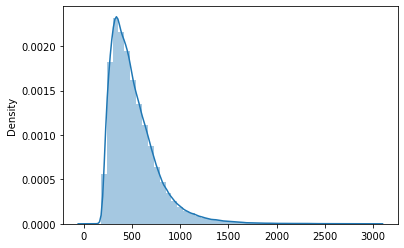

Fold 3 end
Fold 4 start
(2926581, 44)
y dist plot


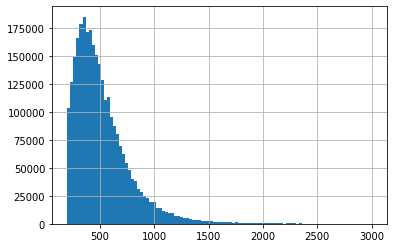

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5926
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 44


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.646665
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.4209
[100]	valid_0's huber: 64.712
[150]	valid_0's huber: 58.6894
[200]	valid_0's huber: 55.0618
[250]	valid_0's huber: 52.6806
[300]	valid_0's huber: 50.85
[350]	valid_0's huber: 49.5065
[400]	valid_0's huber: 48.4833
[450]	valid_0's huber: 47.5059
[500]	valid_0's huber: 46.7317
[550]	valid_0's huber: 46.0242
[600]	valid_0's huber: 45.2906
[650]	valid_0's huber: 44.6586
[700]	valid_0's huber: 44.1376
[750]	valid_0's huber: 43.6325
[800]	valid_0's huber: 43.1609
[850]	valid_0's huber: 42.7458
[900]	valid_0's huber: 42.3608
[950]	valid_0's huber: 42.0035
[1000]	valid_0's huber: 41.7124
[1050]	valid_0's huber: 41.4169
[1100]	valid_0's huber: 41.1339
[1150]	valid_0's huber: 40.8913
[1200]	valid_0's huber: 40.6499
[1250]	valid_0's huber: 40.4058
[1300]	valid_0's huber: 40.1841
[1350]	valid_0's huber: 39.9532
[1400]	valid_0's huber: 39.7436
[1450]	val

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


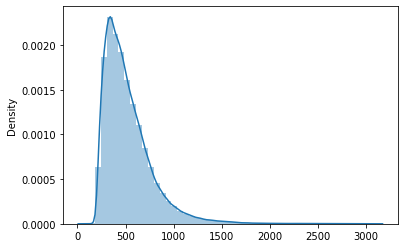

Fold 4 end


<Figure size 432x288 with 0 Axes>

In [26]:
count = 0
oof = np.zeros(training_data_df.shape[0])

shap_summary_df = pd.DataFrame()

for train_idx, val_idx in kf.split(training_data_df):
    print('Fold {} start'.format(count))
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격면적']
    
    print(x_train.shape)
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격면적']
    
    print('y dist plot')
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'learning_rate': 10,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6,
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 10000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
    
    bst.save_model(basedir + 'lightgbm_huber_shap_top_44_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    preds = bst.predict(x_val, num_iteration=bst.best_iteration)
    
    print('preds dist plot')
    sns.distplot(preds)
    plt.show()
    plt.clf()
    
    oof[val_idx] = preds
    
    # shap
    explainer = shap.explainers.Tree(bst)
    
    sample_x = x_val.sample(n=1000)
    sample_y = y_val.loc[sample_x.index]
    
    shap_values = explainer.shap_values(sample_x, y=sample_y, check_additivity=True, approximate=False)
    shap_values_T = shap_values.T
    
    shap_summary = np.zeros(x_val.shape[1])
    
    for i in range(x_val.shape[1]):
        shap_summary[i] = np.mean(np.abs(shap_values_T[i]))
    
    
    shap_summary_df['model_{}_shap_summary'.format(count)] = shap_summary
        
    
    print('Fold {} end'.format(count))
    count += 1

In [27]:
from sklearn.metrics import mean_squared_error

In [28]:
np.sqrt(mean_squared_error(training_data_df['가격면적'], oof))

65.16817379242048

In [29]:
shap_summary_mean = np.zeros(shap_summary_df.shape[0])
for i in range(shap_summary_df.shape[1]):
    shap_summary_mean += shap_summary_df.iloc[:,i]

In [30]:
shap_summary_mean = shap_summary_mean / shap_summary_df.shape[1]

In [31]:
shap_summary_df['shap_summary_mean'] = shap_summary_mean

In [32]:
shap_summary_df.index = x_train.columns

In [33]:
shap_summary_df.to_csv(basedir + 'shap_top_44.csv')

In [34]:
shap_summary_df.head(10)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,94.291030,94.644244,92.757506,92.470771,95.133177,93.859346
공시지가(만원),79.592887,80.152134,77.270997,80.303432,77.470295,78.957949
year_linear,64.068830,64.381504,63.091204,64.391707,66.054345,64.397518
건축년도,50.370523,47.868151,48.426021,50.904730,49.060384,49.325962
전용면적,38.223000,41.397272,38.293735,41.608660,34.694602,38.843454
ynorm,32.149531,32.103976,31.932168,32.627360,30.368998,31.836407
xy,22.432195,21.447759,22.623715,23.049658,20.943867,22.099439
x_2nd,19.286333,17.477047,20.057481,19.946042,19.248369,19.203055
주건축물수,13.874715,12.917700,13.021904,12.950650,13.081337,13.169261
층mean,10.782102,11.753199,10.132729,11.425666,11.522294,11.123198


In [35]:
shap_summary_df.tail(10)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
(한강)폐기물매립시설_설치제한지역,2.063420,2.548997,2.405365,2.313119,2.223843,2.310949
공원,2.199102,2.179518,1.638700,2.423538,1.703377,2.028847
지형형상,1.432040,1.448779,1.332761,1.362905,1.300244,1.375346
x_sin,1.420247,1.384450,1.184654,1.150618,1.549363,1.337867
y_sin,1.257151,1.452957,1.207239,1.255475,1.215714,1.277707
x_cos,1.213285,1.110850,1.205607,1.298823,1.485667,1.262846
y_cos,1.390474,1.493984,1.133802,1.464804,1.228114,1.342236
정비구역,0.900392,1.158580,1.163072,1.065108,0.776536,1.012738
제3종일반주거지역,1.117091,1.044110,1.079556,1.250477,1.120857,1.122418
제1종지구단위계획구역,0.954951,1.056398,1.122337,1.144314,1.096996,1.074999


Fold 6 start
(2926580, 44)
y dist plot


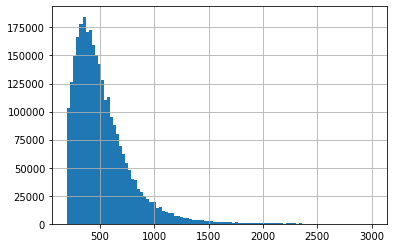

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.171413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5928
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 44
[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 70.3306
[100]	valid_0's huber: 58.6686
[150]	valid_0's huber: 53.8632
[200]	valid_0's huber: 50.9101
[250]	valid_0's huber: 49.0892
[300]	valid_0's huber: 47.6367
[350]	valid_0's huber: 46.3231
[400]	valid_0's huber: 45.3419
[450]	valid_0's huber: 44.5412
[500]	valid_0's huber: 43.8048
[550]	valid_0's huber: 43.172
[600]	valid_0's huber: 42.6205
[650]	valid_0's huber: 42.1057
[700]	valid_0's huber: 41.6722
[750]	valid_0's huber: 41.3083
[800]	valid_0's huber: 40.9611
[850]	valid_0's huber: 40.6168


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [38]:
#count = 0
oof = np.zeros(training_data_df.shape[0])

shap_summary_df = pd.DataFrame()

for train_idx, val_idx in kf.split(training_data_df):
    print('Fold {} start'.format(count))
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격면적']
    
    print(x_train.shape)
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격면적']
    
    print('y dist plot')
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'learning_rate': 15,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6,
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 10000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
    
    break
    
    bst.save_model(basedir + 'lightgbm_huber_shap_top_44_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    preds = bst.predict(x_val, num_iteration=bst.best_iteration)
    
    print('preds dist plot')
    sns.distplot(preds)
    plt.show()
    plt.clf()
    
    oof[val_idx] = preds
    
    # shap
    explainer = shap.explainers.Tree(bst)
    
    sample_x = x_val.sample(n=1000)
    sample_y = y_val.loc[sample_x.index]
    
    shap_values = explainer.shap_values(sample_x, y=sample_y, check_additivity=True, approximate=False)
    shap_values_T = shap_values.T
    
    shap_summary = np.zeros(x_val.shape[1])
    
    for i in range(x_val.shape[1]):
        shap_summary[i] = np.mean(np.abs(shap_values_T[i]))
    
    
    shap_summary_df['model_{}_shap_summary'.format(count)] = shap_summary
        
    
    print('Fold {} end'.format(count))
    count += 1

Fold 6 start
(2926580, 44)
y dist plot


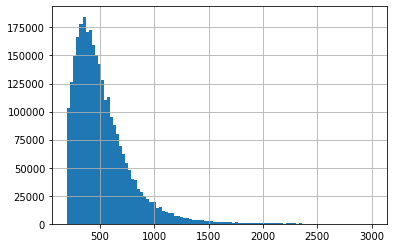

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.163229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5928
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 44
[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 121.916
[100]	valid_0's huber: 95.5493
[150]	valid_0's huber: 82.636
[200]	valid_0's huber: 74.9591
[250]	valid_0's huber: 70.0984
[300]	valid_0's huber: 66.6429
[350]	valid_0's huber: 64.0529
[400]	valid_0's huber: 61.8956
[450]	valid_0's huber: 60.1256
[500]	valid_0's huber: 58.6829
[550]	valid_0's huber: 57.4104
[600]	valid_0's huber: 56.2514
[650]	valid_0's huber: 55.2116
[700]	valid_0's huber: 54.3112
[750]	valid_0's huber: 53.459
[800]	valid_0's huber: 52.8082
[850]	valid_0's huber: 52.2307
[

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [39]:
#count = 0
oof = np.zeros(training_data_df.shape[0])

shap_summary_df = pd.DataFrame()

for train_idx, val_idx in kf.split(training_data_df):
    print('Fold {} start'.format(count))
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격면적']
    
    print(x_train.shape)
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격면적']
    
    print('y dist plot')
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'learning_rate': 3,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6,
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 10000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
    
    break
    
    bst.save_model(basedir + 'lightgbm_huber_shap_top_44_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    preds = bst.predict(x_val, num_iteration=bst.best_iteration)
    
    print('preds dist plot')
    sns.distplot(preds)
    plt.show()
    plt.clf()
    
    oof[val_idx] = preds
    
    # shap
    explainer = shap.explainers.Tree(bst)
    
    sample_x = x_val.sample(n=1000)
    sample_y = y_val.loc[sample_x.index]
    
    shap_values = explainer.shap_values(sample_x, y=sample_y, check_additivity=True, approximate=False)
    shap_values_T = shap_values.T
    
    shap_summary = np.zeros(x_val.shape[1])
    
    for i in range(x_val.shape[1]):
        shap_summary[i] = np.mean(np.abs(shap_values_T[i]))
    
    
    shap_summary_df['model_{}_shap_summary'.format(count)] = shap_summary
        
    
    print('Fold {} end'.format(count))
    count += 1